In [1]:
from lxml import etree
from nltk.tokenize import sent_tokenize, word_tokenize
import re
from collections import Counter
import numpy as np

In [104]:
import os
from fnmatch import fnmatch

root = 'C:/Users/nbq4481/Downloads/adis-20190715T114343Z-001/adis/public_dataset_ADR/train_xml/'
pattern = "*.xml"
all_files = []
for path, subdirs, files in os.walk(root):
    for name in files:
        if fnmatch(name, pattern):
            all_files.append(os.path.join(path, name))

In [105]:

def process_file(root):
    text_map = {}
    
    drug_name = ""
    for node in root.iter():
        
        if "drug" in node.attrib:
            drug_name = node.attrib['drug']
            #print(drug_name)
        
        if node.tag == 'Section':
            sec_id = node.attrib['id']
            if sec_id not in text_map:
                text_map[sec_id] = {}
                text_map[sec_id]['drug'] = []
            text_map[sec_id]['text'] = node.text
            
            if drug_name.lower() in node.text.lower():
                all_indexes = [(m.start(),m.start()+len(drug_name) ) for m in re.finditer(drug_name.lower(), 
                                                                                           node.text.lower())]
                    
                text_map[sec_id]['drug'].extend([(a[0],a[1],drug_name) for a in all_indexes])
        
                #print(text_map[sec_id]['drug'],drug_name)

        if node.tag == 'Mention':
            if node.attrib['type']=="AdverseReaction":
                sec_id = node.attrib['section']

                for s, len1 in zip(node.attrib['start'].split(","),node.attrib['len'].split(",") ):
                    start = int(s)
                    adr_str = node.attrib['str']
                    if 'adr_list' not in text_map[sec_id]:
                        text_map[sec_id]['adr_list'] = []

                    end = start+int(len1)

                    text_map[sec_id]['adr_list'].append((start,end, adr_str))
                    
    return text_map
            
                
def tag_entities_to_sentences(text_map, tokenise_sentence = False):

    sentences = []
    for sec, json in text_map.items():
        text = json['text']
        if 'adr_list' in json:
            adr_list = json['adr_list']
        else:
            adr_list = []
            
        if 'drug' in json:
            drug_list = json['drug']
        else:
            arug_list = []            
        
        if tokenise_sentence:
            para_sent = [y for x in text.split("\n") for y in sent_tokenize(x)]
        else:
            para_sent = [x for x in text.split("\n")]

        offset = 0
        for sen in para_sent:

            if len(sen.strip())<2:
                continue

            ind = text[offset:].index(sen)

            start = offset+ind
            end = start+len(sen)

            sen_adr = []
            
            sen_drug = []
            
            i = 0
            for i , adr in enumerate(adr_list):
                if adr[0]>end:
                    continue
                elif adr[1]<start:
                    continue
                elif adr[1]<=end:
                    sen_adr.append((adr[0]-start,adr[1]-start,adr[2]))


            i = 0
            for i , adr in enumerate(drug_list):
                if adr[0]>end:
                    continue
                elif adr[1]<start:
                    continue
                elif adr[1]<=end:
                    sen_drug.append((adr[0]-start,adr[1]-start,adr[2]))

            sentences.append((sen,sen_adr,sen_drug,sec))
            
            #adr_list = adr_list[i:]

            offset = end
            
    return sentences


def get_token_tags(sen):
    sen1 = []
    tags = []
    text = sen[0]
    tagged_entities = sen[1]
    
    tagged_entities1 = sen[2]
    
    text = re.sub('/|-', ' ', text)
    
    sen_tokens = word_tokenize(text)
    
    offset = 0
    for token in sen_tokens:
        label = 'O'
        
        try:
            ind = text[offset:].index(token)
        except:
            if len(token)>2:
                print("token not present in string",token)
                
#                 print(text)
#                 print(text[offset:])
                
            ind = 0
        
        start = offset+ind
        end = start+len(token)
        
        #print(token,start,end)
        
        i = 0
        for i , adr in enumerate(tagged_entities):
            if adr[0]>start:
                continue
            elif adr[1]<=start:
                continue
            else:
                label = "ADR"

                
        i = 0
        for i , adr in enumerate(tagged_entities1):
            if adr[0]>start:
                continue
            elif adr[1]<=start:
                continue
            else:
                label = "DRUG"
                
        offset = end-1
        
        if len(token)>0:
            sen1.append(token)
            tags.append(label)
            
    return sen1, tags

def merge_sentences(sentences):
    new_sentences = {}
    
    for sen in sentences:
        if sen[0] not in new_sentences:
            new_sentences[sen[0]] = ([],[])

        new_sentences[sen[0]][0].extend(sen[1])
        new_sentences[sen[0]][1].extend(sen[2])
        
    return [(k,v[0],v[1]) for k,v in new_sentences.items()]

In [106]:
all_tagged_data = []
all_sentences = []
for file1 in all_files:
    print(file1)
    root = etree.parse(file1)
    
    text_map = process_file(root)
    
    sentences = tag_entities_to_sentences(text_map, tokenise_sentence = True)
    
    all_sentences.extend(sentences)

sentences = merge_sentences(all_sentences)
print(len(sentences))

for sen_no, sen in enumerate(sentences):

    sen1, tags = get_token_tags(sen)

    all_tagged_data.append((sen,sen1,tags))

C:/Users/nbq4481/Downloads/adis-20190715T114343Z-001/adis/public_dataset_ADR/train_xml/ADCETRIS.xml
C:/Users/nbq4481/Downloads/adis-20190715T114343Z-001/adis/public_dataset_ADR/train_xml/ADREVIEW.xml
C:/Users/nbq4481/Downloads/adis-20190715T114343Z-001/adis/public_dataset_ADR/train_xml/AFINITOR.xml
C:/Users/nbq4481/Downloads/adis-20190715T114343Z-001/adis/public_dataset_ADR/train_xml/AMPYRA.xml
C:/Users/nbq4481/Downloads/adis-20190715T114343Z-001/adis/public_dataset_ADR/train_xml/AMYVID.xml
C:/Users/nbq4481/Downloads/adis-20190715T114343Z-001/adis/public_dataset_ADR/train_xml/APTIOM.xml
C:/Users/nbq4481/Downloads/adis-20190715T114343Z-001/adis/public_dataset_ADR/train_xml/ARCAPTA.xml
C:/Users/nbq4481/Downloads/adis-20190715T114343Z-001/adis/public_dataset_ADR/train_xml/BELEODAQ.xml
C:/Users/nbq4481/Downloads/adis-20190715T114343Z-001/adis/public_dataset_ADR/train_xml/BENLYSTA.xml
C:/Users/nbq4481/Downloads/adis-20190715T114343Z-001/adis/public_dataset_ADR/train_xml/BEPREVE.xml
C:/Users

C:/Users/nbq4481/Downloads/adis-20190715T114343Z-001/adis/public_dataset_ADR/train_xml/VIMIZIM.xml
C:/Users/nbq4481/Downloads/adis-20190715T114343Z-001/adis/public_dataset_ADR/train_xml/VIZAMYL.xml
C:/Users/nbq4481/Downloads/adis-20190715T114343Z-001/adis/public_dataset_ADR/train_xml/VORAXAZE.xml
C:/Users/nbq4481/Downloads/adis-20190715T114343Z-001/adis/public_dataset_ADR/train_xml/XALKORI.xml
C:/Users/nbq4481/Downloads/adis-20190715T114343Z-001/adis/public_dataset_ADR/train_xml/XEOMIN.xml
C:/Users/nbq4481/Downloads/adis-20190715T114343Z-001/adis/public_dataset_ADR/train_xml/XIAFLEX.xml
C:/Users/nbq4481/Downloads/adis-20190715T114343Z-001/adis/public_dataset_ADR/train_xml/XTANDI.xml
C:/Users/nbq4481/Downloads/adis-20190715T114343Z-001/adis/public_dataset_ADR/train_xml/YERVOY.xml
C:/Users/nbq4481/Downloads/adis-20190715T114343Z-001/adis/public_dataset_ADR/train_xml/ZERBAXA.xml
C:/Users/nbq4481/Downloads/adis-20190715T114343Z-001/adis/public_dataset_ADR/train_xml/ZYDELIG.xml
C:/Users/nbq

In [107]:
len(all_tagged_data)

13449

In [108]:
root = 'C:/Users/nbq4481/Downloads/adis-20190715T114343Z-001/adis/public_dataset_ADR/CADEC/CADEC.v2/cadec/original/'
pattern = "*.ann"
label_files = []
for path, subdirs, files in os.walk(root):
    for name in files:
        if fnmatch(name, pattern):
            label_files.append(os.path.join(path, name))

In [109]:
root = 'C:/Users/nbq4481/Downloads/adis-20190715T114343Z-001/adis/public_dataset_ADR/CADEC/CADEC.v2/cadec/text/'
pattern = "*.txt"
data_files = []
for path, subdirs, files in os.walk(root):
    for name in files:
        if fnmatch(name, pattern):
            data_files.append(os.path.join(path, name))

In [110]:
len(label_files),len(data_files)

(1250, 1250)

In [111]:
label_files = {x.split("/")[-1].split(".ann")[0]: x for x in label_files}
data_files = {x.split("/")[-1].split(".txt")[0]: x for x in data_files}

In [112]:
import re
all_data = {}
for file in data_files:
    
    data_file_name = data_files[file]
    labeled_file_name = label_files[file]
    
    with open(data_file_name) as f:
        content = f.readlines()
        
    text = "\n".join([x.strip() for x in content] )

    with open(labeled_file_name) as f:
        raw_text = f.readlines()
    labels = [x.strip() for x in raw_text if re.match("^T\d{0,4}\tADR*",x) ] 
    
    new_labels = []
    for row in labels:
        for row1 in row.split("\t")[1].split(";"):
            new_labels.append((int(row1.split()[-2]),int(row1.split()[-1]),  row.split("\t")[2]))
        
    labels = [x.strip() for x in raw_text if re.match("^T\d{0,4}\tDrug*",x) ] 
    
    new_labels1 = []
    for row in labels:
        for row1 in row.split("\t")[1].split(";"):
            new_labels1.append((int(row1.split()[-2]),int(row1.split()[-1]),  row.split("\t")[2]))
        

        
    all_data[file] = {}
    
    all_data[file]['text'] = text
    all_data[file]['adr_list'] = new_labels
    all_data[file]['drug'] = new_labels1

In [113]:
new_tagged_data = []
sentences = tag_entities_to_sentences(all_data)
sentences = merge_sentences(sentences)
print(len(sentences))

for sen_no, sen in enumerate(sentences):

    sen1, tags = get_token_tags(sen)

    new_tagged_data.append((sen,sen1,tags))

7483


In [114]:
with open("C:/Users/nbq4481/Downloads/adis-20190715T114343Z-001/adis/public_dataset_ADR/ADE-Corpus-V2/ADE-Corpus-V2/DRUG-AE.rel") as f:
    content = f.readlines()
content = [x.strip() for x in content] 

In [115]:
def map_string_to_json(x):
    new_json = {}
    x = x.split("|")
    new_json['text'] = x[1]
    
    new_json['adr_list'] = [(x[1].index(x[2]),x[1].index(x[2])+len(x[2]),x[2])]
    
    new_json['drug'] = [(x[1].index(x[5]),x[1].index(x[5])+len(x[5]),x[5])]
    
    return new_json
    
new_data = {x: map_string_to_json(x) for x in content}


In [116]:
new_tagged_data1 = []
sentences = tag_entities_to_sentences(new_data)
sentences = merge_sentences(sentences)
print(len(sentences))

for sen_no, sen in enumerate(sentences):

    sen1, tags = get_token_tags(sen)

    new_tagged_data1.append((sen,sen1,tags))

4271


In [117]:
len(new_tagged_data1), len(all_tagged_data), len(new_tagged_data)

(4271, 13449, 7483)

In [330]:
sum([len(set(row[0][1])) for row in all_tagged_data+new_tagged_data+new_tagged_data1])  #total entities in all_tagged_data

27547

In [324]:
all_tagged_data[0]

(('    6 ADVERSE REACTIONS', [], []),
 ['6', 'ADVERSE', 'REACTIONS'],
 ['O', 'O', 'O'])

In [328]:
[(row, len(row[0][2]), len([ 1 for a in row[2] if a=="DRUG"])
 )  for row in all_tagged_data+new_tagged_data+new_tagged_data1 if 
 len(row[0][2])> len([ 1 for a in row[2] if a=="DRUG"])]  #total entities in all_tagged_data

[((('The most common adverse reaction leading to AFINITOR dose adjustment was stomatitis.',
    [(73, 83, 'stomatitis'), (73, 83, 'stomatitis')],
    [(44, 52, 'afinitor'), (44, 52, 'afinitor')]),
   ['The',
    'most',
    'common',
    'adverse',
    'reaction',
    'leading',
    'to',
    'AFINITOR',
    'dose',
    'adjustment',
    'was',
    'stomatitis',
    '.'],
   ['O', 'O', 'O', 'O', 'O', 'O', 'O', 'DRUG', 'O', 'O', 'O', 'ADR', 'O']),
  2,
  1),
 ((('                    AFINITOR         N=79      Placebo         N=39',
    [],
    [(20, 28, 'afinitor'), (20, 28, 'afinitor')]),
   ['AFINITOR', 'N=79', 'Placebo', 'N=39'],
   ['DRUG', 'O', 'O', 'O']),
  2,
  1),
 ((('                    AFINITOR    N=78      Placebo    N=39',
    [],
    [(20, 28, 'afinitor'), (20, 28, 'afinitor')]),
   ['AFINITOR', 'N=78', 'Placebo', 'N=39'],
   ['DRUG', 'O', 'O', 'O']),
  2,
  1),
 ((('Interrupt or discontinue BLINCYTO as recommended.',
    [],
    [(25, 33, 'blincyto'),
     (25, 33, 'blinc

In [321]:
all_tagged_data[20][0]

(' In Studies 1 and 2, the most common adverse reactions (>=20%), regardless of causality, were neutropenia, peripheral sensory neuropathy, fatigue, nausea, anemia, upper respiratory tract infection, diarrhea, pyrexia, rash, thrombocytopenia, cough, and vomiting.',
 [(94, 105, 'neutropenia'),
  (107, 136, 'peripheral sensory neuropathy'),
  (138, 145, 'fatigue'),
  (147, 153, 'nausea'),
  (155, 161, 'anemia'),
  (163, 196, 'upper respiratory tract infection'),
  (198, 206, 'diarrhea'),
  (208, 215, 'pyrexia'),
  (217, 221, 'rash'),
  (223, 239, 'thrombocytopenia'),
  (241, 246, 'cough'),
  (252, 260, 'vomiting')],
 [])

In [119]:
sum([len(row[1]) for row in all_tagged_data])

250482

In [120]:
sum([ len([a for a in row[2] if a=='ADR']) for row in all_tagged_data ])

23133

In [121]:
sum([ len([a for a in row[2] if a=='O']) for row in all_tagged_data ])

222673

In [122]:
sum([ len([a for a in row[2] if a=='DRUG']) for row in all_tagged_data ])

4676

In [123]:
import os
from fnmatch import fnmatch

root = 'Data_shared_from_CA_tool_jignesh/March2019-sets/'
pattern = "*.xml"
all_files = []
for path, subdirs, files in os.walk(root):
    for name in files:
        if fnmatch(name, pattern):
            all_files.append(os.path.join(path, name))

In [124]:
all_files1 = {row.split("\\")[-1]:row for row in all_files}

In [125]:
len(all_files)

355070

In [126]:
import pandas as pd
df1 = pd.read_excel("ProductData.xlsx")

In [127]:
df = df1[~df1['MedraLLT'].isnull()]

In [128]:
def get_node_text(node):
    text = ""
    if node.text:
        text = node.text
    return text.strip()
    
def get_data_from_file(root):
    title = ""
    abstract = ""
    for node in root.iter():
        if node.tag=='Title':
            title = node.text
        if node.tag=='AbstractText':
            abstract+="\n"+get_node_text(node)
    return title.strip(), abstract.strip()

class FileData:
    def __init__(self, name, path, title, abstract):
        self.name = name
        self.path = path
        self.title = title
        self.abstract = abstract
        

In [ ]:

    for node in root.iter():

        if node.tag=='url':
            node.text = node.text + "New text you wants to add"

In [129]:
file_data = {}
for f_id in set(df['ContentID'].unique()):
    if f_id in all_files1:
        root = etree.parse(all_files1[f_id])
        
        title, abstract = get_data_from_file(root)
        
        title = re.sub('-', '', title)
        title = re.sub('</cite>|<cite>', '', title)

        abstract = re.sub('-', '', abstract)
        abstract = re.sub('</cite>|<cite>', '', abstract)
        
        file_obj = FileData(f_id, all_files1[f_id] , title, abstract)
        
        file_data[f_id] = file_obj

In [130]:
import re

availlable_dataset = {}
searched = set()
file_wise_adr_list = {}
present_terms = {}
not_present_terms = {}

present_drugs = {}
not_present_drugs = {}
file_wise_drug_list = {}
searched_drug = set()

for i, row in df.iterrows():
    
    if row['ArticleSet']!="articleset4":
        continue
        
    if row['ContentID'] not in file_data:
        print("file not availlable",row['ContentID'])
        continue
    
    if row['ContentID'] not in file_wise_adr_list:
        file_wise_adr_list[row['ContentID']] = []
        present_terms[row['ContentID']] = []
        not_present_terms[row['ContentID']] = []
        
        file_wise_drug_list[row['ContentID']] = []
        present_drugs[row['ContentID']] = []
        not_present_drugs[row['ContentID']] = []        
        
    file_wise_adr_list[row['ContentID']].append(row['PrimarySourceReport'])
    file_wise_drug_list[row['ContentID']].append(row['Term'])
    
    f_data = file_data[row['ContentID']]

    text = f_data.title.lower()
    
    s_text = re.sub('-', '', row['PrimarySourceReport'].lower())
    
    if s_text+row['ContentID'] not in searched:

        searched.add(s_text+row['ContentID'])
    
        if s_text in f_data.title.lower() + f_data.abstract.lower():
            present_terms[row['ContentID']].append(row['PrimarySourceReport'])
        else:
            not_present_terms[row['ContentID']].append(row['PrimarySourceReport'])

        if (f_data.title,"title",str(row['ContentID'])) not in availlable_dataset:
            availlable_dataset[(f_data.title,"title",str(row['ContentID']))] = []

        if s_text in text:
            all_indexes = [(m.start(),m.start()+len(s_text) ) for m in re.finditer(s_text, text)]


            availlable_dataset[(f_data.title,"title",str(row['ContentID']))].append(
                [ row['PrimarySourceReport'], all_indexes,"ADR",i ])


        text = f_data.abstract.lower()

        if (f_data.abstract,"abstract",str(row['ContentID'])) not in availlable_dataset:
            availlable_dataset[(f_data.abstract,"abstract",str(row['ContentID']))] = []

        if s_text in text:
            all_indexes = [(m.start(),m.start()+len(s_text) ) for m in re.finditer(s_text, text)]


            availlable_dataset[(f_data.abstract,"abstract",str(row['ContentID']))].append(
                [ row['PrimarySourceReport'], all_indexes,"ADR",i ])
            
    
    s_text = re.sub('-', '', row['Term'].lower())
                
    if s_text+row['ContentID'] not in searched_drug:

        searched_drug.add(s_text+row['ContentID'])
        
        text = f_data.title.lower()
    
        if s_text in f_data.title.lower() + f_data.abstract.lower():
            present_drugs[row['ContentID']].append(row['Term'])
        else:
            not_present_drugs[row['ContentID']].append(row['Term'])

        if (f_data.title,"title",str(row['ContentID'])) not in availlable_dataset:
            availlable_dataset[(f_data.title,"title",str(row['ContentID']))] = []

        if s_text in text:
            all_indexes = [(m.start(),m.start()+len(s_text) ) for m in re.finditer(s_text, text)]


            availlable_dataset[(f_data.title,"title",str(row['ContentID']))].append(
                [ row['Term'], all_indexes,"drug",i ])


        text = f_data.abstract.lower()

        if (f_data.abstract,"abstract",str(row['ContentID'])) not in availlable_dataset:
            availlable_dataset[(f_data.abstract,"abstract",str(row['ContentID']))] = []

        if s_text in text:
            all_indexes = [(m.start(),m.start()+len(s_text) ) for m in re.finditer(s_text, text)]


            availlable_dataset[(f_data.abstract,"abstract",str(row['ContentID']))].append(
                [ row['Term'], all_indexes,"drug",i ])

In [131]:
len(not_present_terms)

959

In [132]:
sum([1 for k,v in not_present_terms.items() if len(v)==0])

425

In [133]:
len([x for y in present_terms.values() for x in y])

1461

In [134]:
len([x for y in not_present_terms.values() for x in y])

956

In [135]:
len(present_terms),len(not_present_terms), len(availlable_dataset)

(959, 959, 1918)

In [136]:
len(df[df['ArticleSet']=="articleset4"]['PrimarySourceReport'].value_counts())

1804

In [137]:
len(df[df['ArticleSet']=="articleset4"].groupby(['PrimarySourceReport','ContentID']).count())

2417

In [138]:
len(df[df['ArticleSet']=="articleset4"].groupby(['Term','ContentID']).count())

2178

In [139]:
len([x for  k, v in not_present_terms.items() for x in v if len(x.split(" "))==1])

131

In [140]:
new_tagged_test_data = []
new_data = {}
for k , v in availlable_dataset.items():
    
    text = k[0]
    
    text_type = k[1]
    
    article_id = k[2]
    
    new_adr_list = []
    new_drug_list = []
    
    for adr in v:
        for ind in adr[1]:
            if adr[2]=='ADR':
                new_adr_list.append((ind[0],ind[1],adr[0]))
            else:
                new_drug_list.append((ind[0],ind[1],adr[0]))
            
    temp = {}
    temp['text'] = text
    temp['adr_list'] = new_adr_list
    temp['drug'] = new_drug_list
    new_data[article_id+"-"+text_type] = temp
            


In [141]:
test_tagged_data = []
sentences = tag_entities_to_sentences(new_data, tokenise_sentence = True)
print(len(sentences))

for sen_no, sen in enumerate(sentences):

    sen1, tags = get_token_tags(sen)

    test_tagged_data.append((sen,sen1,tags))

18625


In [142]:
sum([len(x[1]) for x in test_tagged_data])

385050

In [143]:
all_text_sentences = []

for f_id, f_data in file_data.items():
    
    text = f_data.title + f_data.abstract
    
    text = re.sub('-', ' ', text)
    
    text = re.sub('</cite>|<cite>', '', text).lower()
    
    all_text_sentences.append(text)

In [144]:
len(all_text_sentences)

8146

In [145]:
all_text_sentences = [word_tokenize(row) for row in all_text_sentences]

In [146]:
word_count1 = Counter([x.lower() for y in all_text_sentences for x in y])

In [332]:
len(word_count1)

65062

In [148]:
text_data = []
labels = []

text_data.extend([row[1] for row in all_tagged_data])
labels.extend([row[2] for row in all_tagged_data])

text_data.extend([row[1] for row in new_tagged_data])
labels.extend([row[2] for row in new_tagged_data])

text_data.extend([row[1] for row in new_tagged_data1])
labels.extend([row[2] for row in new_tagged_data1])

In [287]:
len([x for y in labels for x in y])

458195

In [286]:
Counter([x for y in labels for x in y])

Counter({'O': 394434, 'ADR': 51182, 'DRUG': 12579})

In [149]:
len(text_data), len(labels)

(25203, 25203)

In [150]:
sum(len(row) for row in text_data)

458195

In [151]:
sum([ len([a for a in row if a=='O']) for row in labels ])

394434

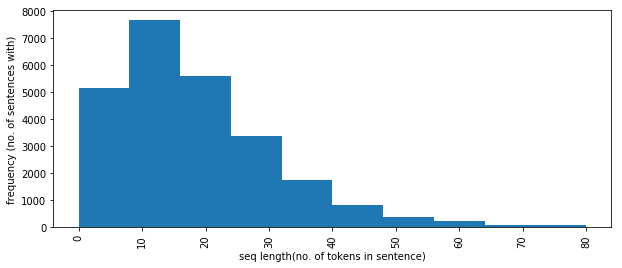

In [152]:
%matplotlib inline
from matplotlib.pylab import rcParams
import matplotlib.pyplot as plt

seq_len = [len(row) for row in text_data]

plt.figure(figsize=(10,4))
plt.hist(seq_len, bins=10, range=[0, 80],   label='train')
plt.xticks(rotation='vertical')
plt.xlabel("seq length(no. of tokens in sentence)")
plt.ylabel("frequency (no. of sentences with)")
plt.show()

In [153]:
len([i for i in seq_len if i >60])

297

In [154]:
max_len = 70

In [155]:
word_count = Counter([x.lower() for y in text_data for x in y])

In [331]:
len(word_count)

15932

In [157]:
len([1 for k,v in word_count.items() if v>1])

9639

In [333]:
len(wordDict)

69677

In [158]:
tags = ['O', 'DRUG', 'ADR']

wordDict = {w: i + 2 for i, w in enumerate(word_count.keys())}
wordDict['dummy'] = 0
wordDict['unknownWord'] = 1
c = len(wordDict)
for w in word_count1.keys():
    if w not in wordDict:
        wordDict[w] = c
        c+=1

tagDict = {t: i for i, t in enumerate(tags)}
wordDictRev = dict(zip(wordDict.values(),wordDict.keys()))
tagDictRev = dict(zip(tagDict.values(),tagDict.keys()))

In [159]:
from keras.preprocessing.sequence import pad_sequences

X = [[wordDict[w.lower()] if word_count[w.lower()]>1 else 1 for w in s ] for s in text_data]
y = [[tagDict[t] for t in st] for st in labels]
X = pad_sequences(maxlen=max_len, sequences=X, padding="post", value=wordDict['dummy'],truncating="post")
y = pad_sequences(maxlen=max_len, sequences=y, padding="post", value=tagDict['O'],truncating="post")

In [160]:

def is_number(s):
    try:
        float(s)
        return True
    except ValueError:
        return False

def get_word_features(word):
    
    word_fea = []
    
    word_fea.append(is_number(word))
    word_fea.append(word.isalpha())
    word_fea.append(word.isalnum() and (not word.isdigit()) and (not word.isalpha()))
    word_fea.append(word[0].isupper())
    word_fea.append(word.isupper())
    word_fea.append(word.islower())
    
    return word_fea

In [161]:
lexical_features = [[get_word_features(w) for w in s ] for s in text_data]
lexical_features = [x[:70] for x in lexical_features]
lexical_features = [x + [[False for i in range(0,len(x[0]))] for j in range(0,max_len-len(x)) ] for x in lexical_features]
lexical_features = np.asarray(lexical_features)

In [162]:
lexical_features.shape

(25203, 70, 6)

In [163]:
max_len_char = 15

In [164]:
chars = set([w_i for w in [x for y in all_text_sentences+text_data for x in y] for w_i in w])
n_chars = len(chars)
print(n_chars)

94


In [165]:
len([len(w) for w in [x for y in all_text_sentences+text_data for x in y]])

2404997

In [166]:
sum([1 for w in [x for y in all_text_sentences+text_data for x in y] if len(w)>15])

27253

In [167]:
char2idx = {c: i + 2 for i, c in enumerate(chars)}
char2idx["UNK"] = 1
char2idx["PAD"] = 0

In [168]:
X_char = []
for sentence in text_data:
    sent_seq = []
    for i in range(max_len):
        word_seq = []
        for j in range(max_len_char):
            try:
                if j<len(sentence[i]):
                    word_seq.append(char2idx.get(sentence[i][len(sentence[i])-j-1]))
                else:
                    word_seq.append(char2idx.get("PAD"))
            except:
                word_seq.append(char2idx.get("PAD"))
        sent_seq.append(word_seq[::-1])
    X_char.append(np.array(sent_seq))
    
X_char = np.asanyarray(X_char)

In [169]:
X_char.shape

(25203, 70, 15)

In [249]:
import gensim

# Load pre-trained Word2Vec model.
pretrained_ebd_model = gensim.models.KeyedVectors.load_word2vec_format("C:/Users/nbq4481/Downloads/wikipedia-pubmed-and-PMC-w2v.bin",binary=True)

C:\Anaconda\lib\site-packages\smart_open\smart_open_lib.py:398: UserWarning: This function is deprecated, use smart_open.open instead. See the migration notes for details: https://github.com/RaRe-Technologies/smart_open/blob/master/README.rst#migrating-to-the-new-open-function
  'See the migration notes for details: %s' % _MIGRATION_NOTES_URL


In [323]:
import gensim

# Load pre-trained Word2Vec model.
pretrained_ebd_model1 = gensim.models.KeyedVectors.load_word2vec_format("C:/Users/nbq4481/Downloads/pubmed+wiki+pitts-nopunct-lower-cbow-n10.bin",binary=True)

C:\Anaconda\lib\site-packages\smart_open\smart_open_lib.py:398: UserWarning: This function is deprecated, use smart_open.open instead. See the migration notes for details: https://github.com/RaRe-Technologies/smart_open/blob/master/README.rst#migrating-to-the-new-open-function
  'See the migration notes for details: %s' % _MIGRATION_NOTES_URL


In [305]:
import gensim

# Load pre-trained Word2Vec model.
pretrained_ebd_model2 = gensim.models.KeyedVectors.load_word2vec_format("C:/Users/nbq4481/Downloads/pubmed2018_w2v_200D/pubmed2018_w2v_200D.bin",binary=True)

C:\Anaconda\lib\site-packages\smart_open\smart_open_lib.py:398: UserWarning: This function is deprecated, use smart_open.open instead. See the migration notes for details: https://github.com/RaRe-Technologies/smart_open/blob/master/README.rst#migrating-to-the-new-open-function
  'See the migration notes for details: %s' % _MIGRATION_NOTES_URL


In [306]:
abw_list = []
EMBEDDING_DIM = 200
num_words = len(wordDict) 
embedding_matrix = np.random.uniform(-0.25, 0.25,(num_words, EMBEDDING_DIM))
abw = 0 
for word, i in wordDict.items():
    if word in pretrained_ebd_model2:
        embedding_matrix[i] = pretrained_ebd_model2[word]
    else:
        abw+=1
        abw_list.append(word)
        pass
        #print(word)

In [308]:
abw

29101

In [177]:
len(wordDict)

69677

In [307]:
pretrained_ebd_model  =None

In [224]:
EMBEDDING_DIM = 300
num_words = len(wordDict) 
abw = 0
pw = 0 
embedding_matrix_glove = np.random.uniform(-0.25, 0.25,(num_words, EMBEDDING_DIM))

f = open(r"C:\Users\nbq4481\Downloads\glove.840B.300d\glove.840B.300d.txt",encoding="utf8")
for line in f:
    try:
        values = line.split()
        word = values[0]
        coefs = np.asarray(values[1:], dtype='float32')

        if word in wordDict and wordDict[word]<num_words:
            embedding_matrix_glove[wordDict[word]] = coefs
            pw+=1
        else:
            abw+=1
    except:
        pass
f.close()

In [179]:
X.shape, y.shape

((25203, 70), (25203, 70))

In [180]:
from keras.utils import to_categorical
y = [to_categorical(i, num_classes=3) for i in y]

In [181]:
import numpy as np

In [182]:
y = np.asarray(y)

In [183]:
y.shape

(25203, 70, 3)

In [184]:
op_data_dir = "processed_data_file/"

In [185]:
indices1 = np.arange(X.shape[0])
np.random.shuffle(indices1)
lexical_features = lexical_features[indices1]
X_char = X_char[indices1]
X = X[indices1]
y = y[indices1]


In [175]:
# np.save(op_data_dir+"X", X)
# np.save(op_data_dir+"y", y)

In [176]:
# import json

# json = json.dumps(wordDict)
# f = open(op_data_dir+"dict.json","w")
# f.write(json)
# f.close()

In [186]:
X.shape, y.shape

((25203, 70), (25203, 70, 3))

In [187]:
split_ind = int(len(X)*0.90)

In [188]:
Xtrain = X[:split_ind]
Xval = X[split_ind:]
X_char_train = X_char[:split_ind]
X_char_val = X_char[split_ind:]
lexical_features_train = lexical_features[:split_ind]
lexical_features_test = lexical_features[split_ind:]

ytrain = y[:split_ind]
yval = y[split_ind:]

In [189]:
Xtrain.shape, Xval.shape

((22682, 70), (2521, 70))

In [190]:
from keras.models import Model, Input
from keras.layers import LSTM, Embedding, Dense, TimeDistributed, Dropout, Bidirectional, BatchNormalization, \
Convolution1D, MaxPooling1D, Flatten, GlobalAveragePooling1D, GlobalMaxPooling1D
from keras_contrib.layers import CRF
from keras.callbacks import EarlyStopping
from keras.layers import concatenate

In [363]:
def get_conv_graph1(filter_sizes,no_filters,ip_shape):
    graph_in = Input(shape=ip_shape)
    convs = []              
    for fsz in filter_sizes:
        conv = Convolution1D(filters=no_filters,        
                              kernel_size=fsz,
                                 padding="same",
                                 activation='relu',)(graph_in)
        
#         avg_pool = GlobalAveragePooling1D()(conv)
#         max_pool = GlobalMaxPooling1D()(conv)

#         pool = concatenate([avg_pool, max_pool])  

        pool = MaxPooling1D(pool_length=3)(conv)    
        convs.append(pool)

    if len(filter_sizes) > 1:
        out = concatenate(convs)
    else:
        out = convs[0]
    
    graph = Model(input=graph_in, output=out)
    return graph

def Char_cnn():
    
    input_data = Input(shape=(max_len_char,),)

    emb_ip = Embedding(input_dim=n_chars + 2, output_dim= char_EMBEDDING_DIM,
                               input_length=max_len_char)(input_data)
    
    graph = get_conv_graph1([2,3,4],20,(max_len_char,char_EMBEDDING_DIM))
    
    conv1 = graph(emb_ip)
    
    x = Dropout(0.3)(conv1)
    
    out = LSTM(units=30, return_sequences=False,
                                    recurrent_dropout=0.3)(x)
    
#     graph = get_conv_graph1([2,3],30,(int(conv1.shape[1]),int(conv1.shape[2])))
    
#     conv1 = graph(x)    
    
#     x = Dropout(0.3)(conv1)
    
#     #x = BatchNormalization()(x)
    
#     #x = LSTM(30, dropout=0.2)(x)
    
    
#     graph = get_conv_graph1([2,3],7,(int(conv1.shape[1]),int(conv1.shape[2])))
    
#     conv1 = graph(x) 
    
#     x = Dropout(0.2)(conv1)
    
#     graph = get_conv_graph1([2,3],5,(int(conv1.shape[1]),int(conv1.shape[2])))
    
#     conv1 = graph(x) 
    
#     flatten = Flatten()(x)
    
#     out = Dense(30,activation='relu')(flatten)
    
    model = Model(input=input_data, output=out)

    return model

In [365]:
Char_cnn().summary()

C:\Anaconda\lib\site-packages\ipykernel_launcher.py:15: UserWarning: Update your `MaxPooling1D` call to the Keras 2 API: `MaxPooling1D(pool_size=3)`
  from ipykernel import kernelapp as app
C:\Anaconda\lib\site-packages\ipykernel_launcher.py:23: UserWarning: Update your `Model` call to the Keras 2 API: `Model(inputs=Tensor("in..., outputs=Tensor("co...)`


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_32 (InputLayer)        (None, 15)                0         
_________________________________________________________________
embedding_21 (Embedding)     (None, 15, 6)             576       
_________________________________________________________________
model_22 (Model)             (None, 5, 60)             1140      
_________________________________________________________________
dropout_24 (Dropout)         (None, 5, 60)             0         
_________________________________________________________________
lstm_14 (LSTM)               (None, 30)                10920     
Total params: 12,636
Trainable params: 12,636
Non-trainable params: 0
_________________________________________________________________


C:\Anaconda\lib\site-packages\ipykernel_launcher.py:67: UserWarning: Update your `Model` call to the Keras 2 API: `Model(inputs=Tensor("in..., outputs=Tensor("ls...)`


In [366]:
embeding_layer1 = Embedding(input_dim= len(wordDict), output_dim=200, weights = [embedding_matrix],
                  input_length=max_len, mask_zero=True)
char_EMBEDDING_DIM = 6
embeding_layer_glove = Embedding(input_dim= len(wordDict), output_dim=300, weights = [embedding_matrix_glove],
                  input_length=max_len, mask_zero=True)

char_emb_layer = Embedding(input_dim=n_chars + 2, output_dim= char_EMBEDDING_DIM,
                               input_length=max_len_char, mask_zero=True)

def create_model(embeding_layer, max_len):
    
    seq_input = Input(shape=(max_len,))
    char_in = Input(shape=(max_len, max_len_char,))
    word_lexical_features = Input(shape=(max_len, 6,))
    
    emb_word = embeding_layer(seq_input)
    
#     lstm = Bidirectional(LSTM(units=80, return_sequences=True,
#                                recurrent_dropout=0.3))(x)      
    
    #x = Dropout(0.3)(lstm)

#     emb_char = TimeDistributed(char_emb_layer)(char_in)
#     # character LSTM to get word encodings by characters
#     char_enc = TimeDistributed(LSTM(units=20, return_sequences=False,
#                                     recurrent_dropout=0.3))(emb_char)
    
    char_cnn_model = Char_cnn()
    
    word_cnn_enc = TimeDistributed(char_cnn_model)(char_in)

    x = concatenate([emb_word, word_lexical_features, word_cnn_enc])   #char_enc,
    
    x = TimeDistributed(BatchNormalization())(x)
    
    x = Dropout(0.2)(x)
        
    lstm = Bidirectional(LSTM(units=100, return_sequences=True,
                               recurrent_dropout=0.3))(x)  
    
    lstm = Dropout(0.3)(lstm)
    
    dense = TimeDistributed(Dense(50, activation="relu"))(lstm)
    
    dense = Dropout(0.2)(dense)
    
    #out = TimeDistributed(Dense(3, activation="softmax"))(dense)
    
    #model = Model(inputs =[seq_input,char_in,word_lexical_features], outputs = out)

    #model.compile(optimizer="rmsprop", loss="categorical_crossentropy", metrics=['acc'], sample_weight_mode="temporal" )
    
    crf = CRF(3)
    
    out = crf(dense)
    
    

    model = Model(inputs =[seq_input,char_in,word_lexical_features], outputs = out)

    model.compile(optimizer="rmsprop", loss=crf.loss_function, metrics=[crf.accuracy] )
    
    return model

In [367]:
w2v_model = create_model(embeding_layer1, max_len)

C:\Anaconda\lib\site-packages\ipykernel_launcher.py:15: UserWarning: Update your `MaxPooling1D` call to the Keras 2 API: `MaxPooling1D(pool_size=3)`
  from ipykernel import kernelapp as app
C:\Anaconda\lib\site-packages\ipykernel_launcher.py:23: UserWarning: Update your `Model` call to the Keras 2 API: `Model(inputs=Tensor("in..., outputs=Tensor("co...)`
C:\Anaconda\lib\site-packages\ipykernel_launcher.py:67: UserWarning: Update your `Model` call to the Keras 2 API: `Model(inputs=Tensor("in..., outputs=Tensor("ls...)`
C:\Anaconda\lib\site-packages\keras_contrib\layers\crf.py:346: UserWarning: CRF.loss_function is deprecated and it might be removed in the future. Please use losses.crf_loss instead.
  warnings.warn('CRF.loss_function is deprecated '
C:\Anaconda\lib\site-packages\keras_contrib\layers\crf.py:353: UserWarning: CRF.accuracy is deprecated and it might be removed in the future. Please use metrics.crf_accuracy
  warnings.warn('CRF.accuracy is deprecated and it '


In [239]:
glove_model = create_model(embeding_layer_glove, max_len)

C:\Anaconda\lib\site-packages\ipykernel_launcher.py:15: UserWarning: Update your `MaxPooling1D` call to the Keras 2 API: `MaxPooling1D(pool_size=3)`
  from ipykernel import kernelapp as app
C:\Anaconda\lib\site-packages\ipykernel_launcher.py:23: UserWarning: Update your `Model` call to the Keras 2 API: `Model(inputs=Tensor("in..., outputs=Tensor("co...)`
C:\Anaconda\lib\site-packages\ipykernel_launcher.py:67: UserWarning: Update your `Model` call to the Keras 2 API: `Model(inputs=Tensor("in..., outputs=Tensor("ls...)`
C:\Anaconda\lib\site-packages\keras_contrib\layers\crf.py:346: UserWarning: CRF.loss_function is deprecated and it might be removed in the future. Please use losses.crf_loss instead.
  warnings.warn('CRF.loss_function is deprecated '
C:\Anaconda\lib\site-packages\keras_contrib\layers\crf.py:353: UserWarning: CRF.accuracy is deprecated and it might be removed in the future. Please use metrics.crf_accuracy
  warnings.warn('CRF.accuracy is deprecated and it '


In [368]:
#out = TimeDistributed(Dense(2, activation="softmax"))(model)
#model.compile(optimizer="rmsprop", loss="categorical_crossentropy", metrics=["accuracy"])
w2v_model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_34 (InputLayer)           (None, 70)           0                                            
__________________________________________________________________________________________________
input_35 (InputLayer)           (None, 70, 15)       0                                            
__________________________________________________________________________________________________
embedding_22 (Embedding)        (None, 70, 200)      13935400    input_34[0][0]                   
__________________________________________________________________________________________________
input_36 (InputLayer)           (None, 70, 6)        0                                            
__________________________________________________________________________________________________
time_distr

In [230]:
# earlystop = EarlyStopping(monitor='val_acc', min_delta=0.001, patience=2, verbose=1, mode='auto')
# callbacks_list = [earlystop]
# import numpy as np
# history = model.fit(Xtrain, ytrain, batch_size=32, epochs=1, verbose=1, shuffle=True)

In [312]:
from keras.callbacks import EarlyStopping, ModelCheckpoint

file_path= "weights_base.best.hdf5"

checkpoint = ModelCheckpoint(file_path, monitor='val_crf_viterbi_accuracy', verbose=1, save_best_only=True, mode='max')

early = EarlyStopping(monitor="val_crf_viterbi_accuracy", mode="max", patience=3)

callbacks_list = [checkpoint, early] 

In [197]:
#sample_weight = np.asanyarray([[1 if y[0]==1 else 2 for y in x] for x in ytrain])

In [313]:
indices = np.arange(Xtrain.shape[0])
np.random.shuffle(indices)
w2v_model.fit([Xtrain[indices],X_char_train[indices],lexical_features_train[indices]], ytrain[indices],
          batch_size=32, epochs=3, callbacks=callbacks_list, 
          validation_data=([Xval,X_char_val,lexical_features_test],yval),verbose=1, shuffle=True)

Train on 22682 samples, validate on 2521 samples
Epoch 1/3
22682/22682 [==============================] - 459s 20ms/step - loss: 6.9227 - crf_viterbi_accuracy: 0.9310 - val_loss: 6.5678 - val_crf_viterbi_accuracy: 0.9534

Epoch 00001: val_crf_viterbi_accuracy improved from -inf to 0.95342, saving model to weights_base.best.hdf5
Epoch 2/3
22682/22682 [==============================] - 492s 22ms/step - loss: 6.8620 - crf_viterbi_accuracy: 0.9519 - val_loss: 6.5535 - val_crf_viterbi_accuracy: 0.9597

Epoch 00002: val_crf_viterbi_accuracy improved from 0.95342 to 0.95970, saving model to weights_base.best.hdf5
Epoch 3/3
22682/22682 [==============================] - 467s 21ms/step - loss: 6.8464 - crf_viterbi_accuracy: 0.9578 - val_loss: 6.5457 - val_crf_viterbi_accuracy: 0.9613

Epoch 00003: val_crf_viterbi_accuracy improved from 0.95970 to 0.96125, saving model to weights_base.best.hdf5


In [318]:
indices = np.arange(Xtrain.shape[0])
np.random.shuffle(indices)
w2v_model.fit([Xtrain[indices],X_char_train[indices],lexical_features_train[indices]], ytrain[indices],
          batch_size=32, epochs=1, callbacks=callbacks_list, 
          validation_data=([Xval,X_char_val,lexical_features_test],yval),verbose=1, shuffle=True)

Train on 22682 samples, validate on 2521 samples
Epoch 1/1
22682/22682 [==============================] - 441s 19ms/step - loss: 6.8317 - crf_viterbi_accuracy: 0.9639 - val_loss: 6.5404 - val_crf_viterbi_accuracy: 0.9630

Epoch 00001: val_crf_viterbi_accuracy did not improve from 0.96351


In [183]:
#w2v_model.load_weights("experiment_results/Model_weigths_2.h5")
#model.load_weights("saved_models/trainable_false_weights_base.best.hdf5")

In [369]:
w2v_model.load_weights("experiment_results/drug-adr1/Model_weigths_4.h5")

In [314]:
import os.path
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
def write_results(exprements_results_dir, no_epocs, batch_size, model_desc, model, yval, Xval):
    
    fp = open(exprements_results_dir+"All_results", "a")
    
    model_no = 1
    model_weight_file = exprements_results_dir+"Model_weigths_"+str(model_no)+".h5"
    
    while(os.path.exists(model_weight_file)):
        model_no+=1
        model_weight_file = exprements_results_dir+"Model_weigths_"+str(model_no)+".h5"
        
    model_weight_file = exprements_results_dir+"Model_weigths_"+str(model_no)+".h5"
    model_structure_file = exprements_results_dir+"model_structure_"+str(model_no)+".json"
    

    model_json = model.to_json()
    with open(model_structure_file, "w") as json_file:
        json_file.write(model_json)
        
    model.save_weights(model_weight_file)

    fp.write("Model no : "+str(model_no))
    fp.write("\n")
    fp.write("Model Desc : "+model_desc)
    fp.write("\n")
    fp.write("Batch size : "+str(batch_size))
    fp.write("\n")
    fp.write("No. of epocs : "+str(no_epocs))
    fp.write("\n\n")
    
    prediction1 = model.predict(Xval)
    test_pred1 = model.predict([testX,test_X_char,test_lexical_features])

    
    prediction = np.argmax(prediction1, axis=-1)
    
    acc = accuracy_score([y for x in np.argmax(yval, axis=-1) for y in x],
                            [y for x in prediction for y in x])
    
    fp.write("Model acc : "+str(acc))
    fp.write("\n")
    fp.write("Model instant accuracy : "+ str(sum([1 if sum(x==y)==len(x) else 0 for x,y in zip(np.argmax(yval, axis=-1),
                                                                                            prediction)])/len(yval)))
    fp.write("\nClassificaton report : \n")
    fp.write(str(classification_report([y for x in np.argmax(yval, axis=-1) for y in x],
                            [y for x in prediction for y in x],target_names= tags)))
    
    fp.write("\nConfusion Matrix : \n")
    fp.write(str(confusion_matrix([y for x in np.argmax(yval, axis=-1) for y in x],
                            [y for x in prediction for y in x])))
    
    

    test_pred = np.argmax(test_pred1, axis=-1)
    
    fp.write("\nClassificaton report on test data : \n")
    fp.write(str(classification_report([y for x in testy for y in x],
                            [y for x in test_pred for y in x],target_names= tags)))
    
    fp.write("\nConfusion Matrix on test data: \n")
    fp.write(str(confusion_matrix([y for x in testy for y in x],
                            [y for x in test_pred for y in x])))    

    
    fp.write("\n\n\n")
    
    fp.close()
    

In [319]:
exprements_results_dir = "experiment_results/drug-adr1/"
write_results(exprements_results_dir, 5, 32, """pubmed2018 pretrained embeding + lexical features + cnn char embedding 
                + batchnorm + dropout """, w2v_model, yval, 
             [Xval,X_char_val,lexical_features_test])

In [529]:
prediction = w2v_model.predict([Xval,X_char_val,lexical_features_test])

In [452]:
prediction.shape,  np.argmax(yval, axis=-1).shape

((2521, 70), (2521, 70))

In [153]:
prediction = glove_model.predict(np.array(Xval))

In [156]:
prediction = np.argmax(prediction, axis=-1)

In [236]:
accuracy_score([y for x in np.argmax(yval, axis=-1) for y in x],
                            [y for x in prediction for y in x])

0.9919249730832436

In [570]:
from sklearn.metrics import classification_report
print(classification_report([y for x in np.argmax(yval, axis=-1) for y in x],
                            [y for x in prediction for y in x],target_names= ["O","ADR"]))



              precision    recall  f1-score   support

           O       0.99      0.99      0.99    146452
         ADR       0.80      0.80      0.80      4808

   micro avg       0.99      0.99      0.99    151260
   macro avg       0.90      0.90      0.90    151260
weighted avg       0.99      0.99      0.99    151260



In [697]:
from sklearn.metrics import confusion_matrix

confusion_matrix([y for x in np.argmax(yval, axis=-1) for y in x],
                            [y for x in prediction for y in x])

array([[171011,    938],
       [   899,   3622]], dtype=int64)

In [571]:
val_text_data = [text_data[i] for i in indices[split_ind:]]

In [698]:
original_tag = np.argmax(yval, axis=-1)

for i, row in enumerate(Xval):
    
    print(val_text_data[i])
    for w, pred, org in zip(row, prediction[i],original_tag[i]):
        if w != 0:
            
            print("{:15} {:5}  {:5}".format(wordDictRev[w], tagDictRev[pred],  tagDictRev[org]))

['*', 'Drugs', 'that', 'act', 'directly', 'on', 'the', 'renin-angiotensin', 'system', 'can', 'cause', 'injury', 'and', 'death', 'to', 'the', 'developing', 'fetus', '.']
severe          O      O    
1               O      O    
0               O      O    
0               O      O    
0               O      O    
0               O      O    
0               O      O    
1               O      O    
(               O      O    
100             O      O    
)               O      O    
['However', ',', 'follow-up', 'revealed', 'that', 'gestational', 'diabetes', 'when', 'associated', 'with', 'norethisterone', 'had', 'a', 'lesser', 'risk', 'of', 'emerging', 'diabetes', 'mellitus', 'and', 'impaired', 'glucose', 'tolerance', '.']
vascular        O      O    
disorders       O      O    
['The', 'median', 'age', 'of', 'patients', 'treated', 'with', 'Teflaro', 'was', '54', 'years', ',', 'ranging', 'between', '18', 'and', '99', 'years', 'old', '.']
this            O      O    
is              O 

the             O      O    
incident        O      O    
antigen         O      O    
(               O      O    
or              O      O    
antigens        O      O    
)               O      O    
and             O      O    
mechanism       O      O    
of              O      O    
action          O      O    
remain          O      O    
unknownWord     O      O    
.               O      O    
['Activated', 'prothrombin', 'complex', 'concentrates', '(', 'aPCCs', ',', 'e.g.', ',', 'FEIBA', ')', ',', 'or', 'recombinant', 'Factor', 'VIIa', ',', 'or', 'concentrates', 'of', 'coagulation', 'factors', 'II', ',', 'IX', 'or', 'X', 'may', 'be', 'considered', 'but', 'their', 'use', 'has', 'not', 'been', 'evaluated', 'in', 'clinical', 'trials', '.']
introduction    O      O    
:               O      O    
although        O      O    
gefitinib       O      O    
used            O      O    
for             O      O    
the             O      O    
treatment       O      O    
of         

,               O      O    
5.1             O      O    
,               O      O    
14.3            O      O    
)               O      O    
.               O      O    
['Motor', 'fluctuations', 'appear', 'after', '2-3', 'years', 'of', 'levodopa', 'treatment', ',', 'and', 'affect', 'at', 'least', '50', '%', 'of', 'patients', 'after', 'five', 'years', '.']
sustained       ADR    ADR  
increases       ADR    ADR  
in              ADR    ADR  
intraocular     ADR    ADR  
pressure        ADR    ADR  
have            O      O    
also            O      O    
been            O      O    
reported        O      O    
after           O      O    
repeated        O      O    
intravitreal    O      O    
dosing          O      O    
with            O      O    
vascular        O      O    
endothelial     O      O    
growth          O      O    
factor          O      O    
(               O      O    
vegf            O      O    
)               O      O    
inhibitors      O      O    

,               O      O    
in              O      O    
>               O      O    
10              O      O    
%               O      O    
of              O      O    
patients        O      O    
in              O      O    
parts           O      O    
1               O      O    
to              O      O    
3               O      O    
of              O      O    
the             O      O    
phase           O      O    
3               O      O    
trial           O      O    
for             O      O    
caps            O      O    
patients        O      O    
['c', 'n', '(', '%', ')', 'indicates', 'number', 'of', 'patients', 'and', 'percent', '.']
more            O      O    
problems        O      O    
and             O      O    
this            O      O    
time            O      O    
i               O      O    
had             O      O    
the             O      O    
ideo            O      O    
to              O      O    
go              O      O    
on         

)               O      O    
.               O      O    
['IV', 'propranolol', 'was', 'used', 'as', 'the', 'initial', 'treatment', 'for', 'his', 'hyperadrenergic', 'state', ',', 'resulting', 'in', 'a', 'decrease', 'in', 'heart', 'rate', 'but', 'a', 'paroxsymal', 'increase', 'in', 'blood', 'pressure', '.']
papilloma       ADR    ADR  
c               O      O    
['We', 'report', 'five', 'cases', 'of', 'restless', 'legs', 'syndrome', '(', 'RLS', ')', 'and', 'periodic', 'limb', 'movements', 'during', 'sleep', '(', 'PLMS', ')', 'that', 'were', 'probably', 'associated', 'with', 'olanzapine', '.']
however         O      O    
the             O      O    
symptoms        O      O    
persisted       O      O    
,               O      O    
gp              O      O    
said            O      O    
``              O      O    
just            O      O    
flu             O      O    
jab             O      O    
''              O      O    
but             O      O    
after           O     

:               O      O    
nausea          ADR    ADR  
(               O      O    
4               O      O    
%               O      O    
)               O      O    
;               O      O    
dizziness       ADR    ADR  
,               O      O    
headache        ADR    ADR  
and             O      O    
vomiting        ADR    ADR  
(               O      O    
2               O      O    
%               O      O    
each            O      O    
)               O      O    
.               O      O    
['And', 'will', 'discuss', 'further', 'with', 'her', '.']
blood           O      O    
and             O      O    
lymphatic       O      O    
system          O      O    
disorders       O      O    
:               O      O    
anemia          ADR    ADR  
,               O      O    
leukopenia      ADR    ADR  
,               O      O    
lymphadenopathy ADR    ADR  
,               O      O    
pancytopenia    ADR    ADR  
,               O      O    
and           

reaction        ADR    ADR  
with            O      O    
flushing        ADR    ADR  
,               O      O    
dyspnea         ADR    ADR  
and             O      O    
chest           ADR    ADR  
pressure        ADR    ADR  
within          O      O    
minutes         O      O    
following       O      O    
vizamyl         O      O    
administration  O      O    
and             O      O    
recovered       O      O    
with            O      O    
treatment       O      O    
.               O      O    
['Evidenced', 'by', 'Brain', 'Biopsy', 'w/', 'Electron', 'Microscopy', ',', 'as', 'well', 'as', 'Serial', 'Lactic', 'Acid', 'levels', 'consitently', 'well', 'above', 'normal', 'range', ',', 'as', 'well', 'as', 'a', 'Muscle', 'Biopsy', 'studied', 'under', 'Electron', 'Microscopy', '.']
adverse         O      O    
reactions       O      O    
reported        O      O    
in              O      O    
the             O      O    
post            O      O    
marketing       O 

i               O      O    
was             O      O    
laying          O      O    
down            O      O    
with            O      O    
my              O      O    
husband         O      O    
and             O      O    
this            O      O    
was             O      O    
similar         O      O    
to              O      O    
an              O      O    
``              O      O    
i               O      O    
just            O      O    
finished        O      O    
running         O      O    
!               O      O    
''              O      O    
heart           ADR    O    
rate            ADR    O    
)               O      O    
,               O      O    
hot             O      ADR  
flashes         O      ADR  
,               O      O    
dizziness       ADR    ADR  
,               O      O    
sever           ADR    ADR  
stomach         ADR    ADR  
cramps          ADR    ADR  
,               O      O    
and             O      O    
weakness      

non             O      O    
us              O      O    
approved        O      O    
filgrastim      O      O    
product         O      O    
)               O      O    
.               O      O    
['I', 'am', 'an', 'unlikely', 'candidate', 'for', 'MND', '.']
*               O      O    
a               O      O    
qtcf            ADR    O    
interval        ADR    O    
of              ADR    O    
greater         ADR    O    
than            ADR    O    
500             ADR    O    
ms              ADR    O    
(               O      O    
confirmed       O      O    
by              O      O    
repeat          O      O    
ecg             O      O    
)               O      O    
['A', 'patient', 'with', 'intracranial', 'osteosarcoma', 'that', 'arose', '16', 'years', 'after', 'radiation', 'therapy', 'for', 'hereditary', 'retinoblastoma', 'developed', 'fatal', 'cerebral', 'edema', 'and', 'brainstem', 'herniation', 'after', 'she', 'received', 'a', 'single', 'dose', 'of', 'intr

unknownWord     O      O    
unknownWord     O      O    
[               O      O    
see             O      O    
adverse         O      O    
reactions       O      O    
(               O      O    
6.1             O      O    
)               O      O    
]               O      O    
.               O      O    
['EXCERPT', ':', '*', 'The', 'most', 'common', 'adverse', 'reactions', 'occurring', 'in', '>', '=3', '%', 'of', 'KALBITOR-treated', 'patients', 'and', 'greater', 'than', 'placebo', 'are', 'headache', ',', 'nausea', ',', 'diarrhea', ',', 'pyrexia', ',', 'injection', 'site', 'reactions', ',', 'and', 'nasopharyngitis', '.']
i               O      O    
've             O      O    
felt            O      O    
no              O      O    
discernible     O      O    
difference      O      O    
in              O      O    
the             O      O    
pain            ADR    O    
in              ADR    O    
my              ADR    O    
hips            ADR    O    
and       

disorders       O      O    
:               O      O    
vision          ADR    ADR  
blurred         ADR    ADR  
.               O      O    
['(', 'I', 'fly', 'alot', ',', 'so', 'I', 'walk', 'throught', 'a', 'lot', 'of', 'airports', '.', ')']
5.1             O      O    
cardiac         O      O    
toxicities      O      O    
['*', 'An', '8-week', 'crossover', 'design', 'trial', '(', 'Trial', '4', ')', 'involving', '39', 'patients', 'between', 'the', 'ages', 'of', '6', 'and', '57', 'years', 'with', 'a', 'G1244E', ',', 'G1349D', ',', 'G178R', ',', 'G551S', ',', 'G970R', ',', 'S1251N', ',', 'S1255P', ',', 'S549N', ',', 'or', 'S549R', 'mutation', 'in', 'the', 'CFTR', 'gene', '.']
tremor          ADR    ADR  
.               O      O    
['5.2', 'Infusion-Related', 'Reactions']
amylase         O      O    
and             O      O    
lipase          O      O    
increase        O      O    
['Nephrotic', 'syndrome', 'related', 'to', 'systemic', 'lupus', 'erythematosus', 'after', 'gr

(               O      O    
158             O      O    
)               O      O    
1.1             O      O    
(               O      O    
153             O      O    
)               O      O    
3.2             O      O    
(               O      O    
377             O      O    
)               O      O    
0.6             O      O    
(               O      O    
89              O      O    
)               O      O    
0.6             O      O    
(               O      O    
156             O      O    
)               O      O    
['We', 'conclude', 'that', '(', 'a', ')', 'cyclophosphamide', 'is', 'a', 'human', 'teratogen', ',', '(', 'b', ')', 'a', 'distinct', 'phenotype', 'exists', ',', 'and', '(', 'c', ')', 'the', 'safety', 'of', 'CP', 'in', 'pregnancy', 'is', 'in', 'serious', 'question', '.']
in              O      O    
vitro           O      O    
studies         O      O    
with            O      O    
human           O      O    
platelets       O      O    
indic

been            O      O    
reported        O      O    
with            O      O    
post            O      O    
marketing       O      O    
tnf             O      O    
blocker         O      O    
use             O      O    
in              O      O    
rheumatoid      O      O    
arthritis       O      O    
and             O      O    
other           O      O    
indications     O      O    
.               O      O    
['Additionally', ',', 'the', 'observed', 'incidence', 'of', 'antibody', '(', 'including', 'neutralizing', 'antibody', ')', 'positivity', 'in', 'an', 'assay', 'may', 'be', 'influenced', 'by', 'several', 'factors', 'including', 'assay', 'methodology', ',', 'sample', 'handling', ',', 'timing', 'of', 'sample', 'collection', ',', 'concomitant', 'medications', ',', 'and', 'underlying', 'disease', '.']
over            O      O    
two             O      O    
years           O      O    
to              O      O    
rid             O      O    
myself          O    

lipitor         O      O    
.               O      O    
['We', 'present', 'a', 'case', 'of', 'photo-onycholysis', 'in', 'a', 'patient', 'treated', 'with', 'doxycycline', 'for', 'acne', 'vulgaris', '.']
in              O      O    
the             O      O    
controlled      O      O    
clinical        O      O    
trials          O      O    
,               O      O    
psychiatric     ADR    ADR  
events          ADR    ADR  
were            O      O    
reported        O      O    
more            O      O    
frequently      O      O    
with            O      O    
benlysta        O      O    
(               O      O    
16              O      O    
%               O      O    
)               O      O    
than            O      O    
with            O      O    
placebo         O      O    
(               O      O    
12              O      O    
%               O      O    
)               O      O    
,               O      O    
related         O      O    
primarily    

on              O      O    
placebo         O      O    
,               O      O    
and             O      O    
occurred        O      O    
in              O      O    
at              O      O    
least           O      O    
5               O      O    
%               O      O    
of              O      O    
patients        O      O    
treated         O      O    
with            O      O    
tanzeum         O      O    
.               O      O    
['back', 'pain', ',', 'aching', 'joints', 'and', 'muscles', ',', 'flatulence', 'and', 'wind', ',', 'hair', 'loss', '.']
discontinue     O      O    
simponi         O      O    
aria            O      O    
if              O      O    
a               O      O    
patient         O      O    
develops        O      O    
a               O      O    
serious         O      O    
infection       O      O    
.               O      O    
['Nausea', '2.4', '2.8', '2.5']
somewhat        O      O    
concerned       O      O    
about  

twice           O      O    
a               O      O    
day             O      O    
and             O      O    
771             O      O    
placebo         O      O    
treated         O      O    
patients        O      O    
.               O      O    
['The', 'rates', 'of', 'treatment-emergent', 'adverse', 'events', '(', 'irrespective', 'of', 'causality', ')', 'resulting', 'in', 'permanent', 'discontinuation', 'were', '14', '%', 'and', '3', '%', 'for', 'the', 'AFINITOR', 'and', 'placebo', 'treatment', 'groups', ',', 'respectively', '.']
perform         O      O    
appropriate     O      O    
monitoring      O      O    
and             O      O    
treat           O      O    
hyperglycemia   O      O    
with            O      O    
insulin         O      O    
,               O      O    
as              O      O    
necessary       O      O    
(               O      O    
5.3             O      O    
)               O      O    
['none', 'that', 'I', "'m", 'aware', 'of',

shifts          O      O    
from            O      O    
baseline        O      O    
to              O      O    
endpoint        O      O    
['Advise', 'families', 'and', 'caregivers', 'of', 'the', 'need', 'for', 'close', 'observation', 'and', 'communication', 'with', 'the', 'prescriber', '[', 'see', 'Warnings', 'and', 'Precautions', '(', '5.1', ')', ']', '.']
a               O      O    
tingling        ADR    ADR  
sensation       ADR    ADR  
in              ADR    ADR  
the             ADR    ADR  
back            ADR    ADR  
of              ADR    ADR  
my              ADR    ADR  
neck            ADR    ADR  
.               O      O    
['*', 'Monitor', 'for', 'dizziness', 'and', 'somnolence', '.']
injection       ADR    ADR  
site            ADR    ADR  
discomfort      ADR    ADR  
and             O      O    
injection       ADR    ADR  
site            ADR    ADR  
pain            ADR    ADR  
were            O      O    
common          O      O    
adverse         O  

)               O      O    
in              O      O    
the             O      O    
controlled      O      O    
and             O      O    
uncontrolled    O      O    
clinical        O      O    
trials          O      O    
in              O      O    
peyronie        O      O    
's              O      O    
disease         O      O    
[               O      O    
see             O      O    
adverse         O      O    
reactions       O      O    
(               O      O    
6               O      O    
)               O      O    
]               O      O    
.               O      O    
['A', 'causal', 'association', 'with', 'single-agent', 'ADCETRIS', 'has', 'not', 'been', 'established', '.']
the             O      O    
incidence       O      O    
of              O      O    
antibody        O      O    
development     O      O    
in              O      O    
patients        O      O    
receiving       O      O    
granix          O      O    
has             O    

877             O      O    
takeda          O      O    
7               O      O    
(               O      O    
1               O      O    
877             O      O    
825             O      O    
unknownWord     O      O    
)               O      O    
or              O      O    
fda             O      O    
at              O      O    
1               O      O    
800             O      O    
fda             O      O    
1088            O      O    
or              O      O    
www.fda.gov/medwatch O      O    
.               O      O    
['Later', 'I', 'got', 'pains', 'so', 'bad', 'that', 'I', 'could', 'not', 'run', '.']
anaphylaxis     ADR    ADR  
4               O      O    
(               O      O    
6.7             O      O    
)               O      O    
0               O      O    
(               O      O    
0               O      O    
)               O      O    
['Any', 'adverse', 'reaction', '100', '41', '9', '90', '22', '5']
after           O      O    
1  

a               O      O    
patient         O      O    
develops        O      O    
a               O      O    
serious         O      O    
infection       O      O    
,               O      O    
and             O      O    
unknownWord     O      O    
the             O      O    
benefits        O      O    
and             O      O    
risks           O      O    
prior           O      O    
to              O      O    
unknownWord     O      O    
of              O      O    
therapy         O      O    
.               O      O    
['See', 'full', 'prescribing']
the             O      O    
following       O      O    
serious         O      O    
and             O      O    
otherwise       O      O    
important       O      O    
adverse         O      O    
reactions       O      O    
are             O      O    
discussed       O      O    
in              O      O    
greater         O      O    
detail          O      O    
in              O      O    
other       

treatment       O      O    
of              O      O    
leukemia        O      O    
,               O      O    
gestational     O      O    
disease         O      O    
and             O      O    
during          O      O    
treatment       O      O    
of              O      O    
psoriasis       O      O    
and             O      O    
rheumatoid      O      O    
arthritis       O      O    
.               O      O    
['We', 'were', 'getting', 'it', 'to', 'lessen', 'our', 'chances', 'of', 'heart', 'attacks', 'and', 'instead', 'it', 'was', 'found', 'to', 'increase', 'the', 'risk', '.']
in              O      O    
the             O      O    
peyronie        O      O    
's              O      O    
disease         O      O    
clinical        O      O    
studies         O      O    
,               O      O    
at              O      O    
6               O      O    
weeks           O      O    
after           O      O    
the             O      O    
first           O 

death           ADR    ADR  
on              O      O    
the             O      O    
unknownWord     O      O    
day             O      O    
.               O      O    
['An', 'increased', 'incidence', 'was', 'observed', 'in', 'patients', 'on', 'the', '300', 'mg', 'dose', '.']
unknownWord     ADR    O    
fatal           ADR    ADR  
bleeding        ADR    ADR  
is              O      O    
an              O      O    
adjudicated     O      O    
death           ADR    ADR  
with            O      O    
the             O      O    
primary         O      O    
cause           O      O    
of              O      O    
death           ADR    ADR  
as              O      O    
intracranial    ADR    ADR  
bleeding        ADR    ADR  
or              O      O    
non             O      ADR  
intracranial    ADR    ADR  
bleeding        ADR    ADR  
during          O      O    
the             O      O    
on              O      O    
treatment       O      O    
period          O    

['Bronchitis', '4', '(', '11', ')']
patients        O      O    
with            O      O    
pre             O      O    
voraxaze        O      O    
methotrexate    O      O    
concentrations  O      O    
>               O      O    
100             O      O    
mumol/l         O      O    
were            O      O    
to              O      O    
receive         O      O    
a               O      O    
second          O      O    
dose            O      O    
of              O      O    
voraxaze        O      O    
48              O      O    
hours           O      O    
after           O      O    
the             O      O    
first           O      O    
dose            O      O    
.               O      O    
['Do', 'NOT', 'fall', 'for', 'the', 'Statin', 'Drug', 'Scam', ',', 'as', 'Big', 'Pharma', 'runs', 'our', 'little', 'Family', 'Dr', 'Offices', 'with', 'Lunches', '&', 'boxes', 'full', 'of', 'Sample', 'drugs', ',', 'to', 'either', 'give', 'to', 'patien', '.']
i         

develop         O      O    
a               O      O    
new             O      O    
infection       O      O    
during          O      O    
treatment       O      O    
with            O      O    
simponi         O      O    
aria            O      O    
,               O      O    
perform         O      O    
a               O      O    
prompt          O      O    
and             O      O    
complete        O      O    
diagnostic      O      O    
workup          O      O    
appropriate     O      O    
for             O      O    
an              O      O    
immunocompromised O      O    
patient         O      O    
and             O      O    
initiate        O      O    
appropriate     O      O    
antimicrobial   O      O    
therapy         O      O    
and             O      O    
closely         O      O    
monitor         O      O    
them            O      O    
.               O      O    
['Based', 'on', 'its', 'mechanism', 'of', 'action', ',', 'ZYKADIA', 'm

stroke          O      O    
,               O      O    
in              O      O    
elderly         O      O    
patients        O      O    
with            O      O    
dementia        O      O    
related         O      O    
psychosis       O      O    
['Regardless', 'of', 'a', 'negative', 'history', 'of', 'asthma', ',', 'therefore', ',', 'life-threatening', 'bronchospasm', 'must', 'be', 'considered', 'a', 'possible', 'complication', 'of', 'propranolol', 'therapy', '.']
decreases       ADR    ADR  
in              ADR    ADR  
hemoglobin      ADR    ADR  
,               O      O    
neutrophils     ADR    ADR  
,               O      O    
and             O      O    
platelets       ADR    ADR  
may             O      O    
also            O      O    
occur           O      O    
.               O      O    
['Observational', 'studies', 'suggest', 'that', ',', 'similar', 'to', 'atypical', 'antipsychotic', 'drugs', ',', 'treatment', 'with', 'conventional', 'antipsychotic', 'd

['We', 'present', 'the', 'first', 'case', 'of', 'WES', 'in', 'an', 'infant', 'born', 'to', 'a', 'mother', 'taking', 'haloperidol', 'during', 'her', 'pregnancy', '.']
feels           O      O    
like            O      O    
menstrual       ADR    O    
cramps          ADR    O    
,               O      O    
back            ADR    O    
ache            ADR    O    
,               O      O    
sick            ADR    O    
to              ADR    O    
stomach         ADR    O    
for             O      O    
24              O      O    
hours           O      O    
+               O      O    
.               O      O    
['EXCERPT', ':', 'The', 'most', 'common', 'adverse', 'reactions', '(', 'incidence', '>', '=25', '%', ')', 'were', 'neutropenia', ',', 'anemia', ',', 'asthenia/fatigue', ',', 'alopecia', ',', 'peripheral', 'neuropathy', ',', 'nausea', ',', 'and', 'constipation', '(', '6', ')']
*               O      O    
hepatotoxicity  ADR    ADR  
:               O      O    
beleod

In [200]:
testX = [[wordDict[w.lower()] if w.lower() in wordDict else 1 for w in s[1] ] for s in test_tagged_data]
testy = [[tagDict[t] for t in st[2]] for st in test_tagged_data]
testX = pad_sequences(maxlen=max_len, sequences=testX, padding="post", value=wordDict['dummy'], truncating="post")
testy = pad_sequences(maxlen=max_len, sequences=testy, padding="post", value=tagDict['O'], truncating="post")

In [201]:
test_lexical_features = [[get_word_features(w) for w in s[1] ] for s in test_tagged_data]
test_lexical_features = [x[:70] for x in test_lexical_features]
test_lexical_features = [x + [[False for i in range(0,len(x[0]))] for j in range(0,max_len-len(x)) ]
                         for x in test_lexical_features]
test_lexical_features = np.asarray(test_lexical_features)

In [202]:
test_X_char = []
for sentence1 in test_tagged_data:
    sentence = sentence1[1]
    sent_seq = []
    for i in range(max_len):
        word_seq = []
        for j in range(max_len_char):
            try:
                if j<len(sentence[i]):
                    word_seq.append(char2idx.get(sentence[i][len(sentence[i])-j-1]))
                else:
                    word_seq.append(char2idx.get("PAD"))
            except:
                word_seq.append(char2idx.get("PAD"))
        sent_seq.append(word_seq[::-1])
    test_X_char.append(np.array(sent_seq))
    
test_X_char = np.asanyarray(X_char)

In [255]:
test_pred = w2v_model.predict([testX,test_X_char,test_lexical_features])
test_pred = np.argmax(test_pred, axis=-1)

In [256]:
accuracy_score([y for x in testy for y in x],
                            [y for x in test_pred for y in x])

0.9715114093959731

In [257]:
print(classification_report([y for x in testy for y in x],
                            [y for x in test_pred for y in x],target_names= ["O","DRUG","ADR"]))


              precision    recall  f1-score   support

           O       1.00      0.97      0.99   1293022
        DRUG       0.45      0.83      0.58      5456
         ADR       0.12      0.78      0.21      5272

   micro avg       0.97      0.97      0.97   1303750
   macro avg       0.52      0.86      0.59   1303750
weighted avg       0.99      0.97      0.98   1303750



In [264]:
file_wise_results = {}

for i, row in enumerate(testX):
    
    file_name = test_tagged_data[i][0][3]

#     if len([1 for x in testy[i] if x==1])==0:
#         continue
    
#     if len(test_tagged_data[i][1])<70:
#         continue
    #print(test_tagged_data[i])
    
    if file_name not in file_wise_results:
        file_wise_results[file_name] = []
                
    sent_results = []     
    
    sent_pred = test_pred[i]
    
    if len(sent_pred)<len(test_tagged_data[i][1]):
        
        #print(len(test_tagged_data[i][1]))
        
        sent_pred = list(sent_pred) + [0 for i in range(0,len(test_tagged_data[i][1])- len(sent_pred))]
    
    
    
    for w, pred, org in zip(test_tagged_data[i][1], sent_pred, test_tagged_data[i][2]):
        if w != 0:
            
            sent_results.append((w, tagDictRev[pred],  org))
    
    file_wise_results[file_name].append(sent_results)
            
            #print("{:15} {:5}  {:5}".format(w, tagDictRev[pred],  org))

In [265]:
# import csv
# op_dir = "first_results/"

# for file1,val in file_wise_results.items():
    
#     f = open(op_dir+file1+".tsv", "w")
    
#     for row in val:
        
#         for token in row:
#             f.write(token[0]+"\t"+token[1]+"\t"+token[2]+"\n")
        
#         f.write("\n\n")
    
#     f.close()

In [266]:
sum([len(val) for k, val in file_wise_results.items()])

18625

In [267]:
new_file_wise_results = {}
for file1,val in file_wise_results.items():
    file_name = file1.split("-")[0]
    t_type = file1.split("-")[1]
    
    if file_name not in new_file_wise_results:
        new_file_wise_results[file_name] = {}
    new_file_wise_results[file_name][t_type] = val
    

In [268]:
from docx import Document
from docx.shared import RGBColor

op_dir = "results/"

document = Document()

document.add_heading('ADR-DRUG prediction results', 0)


for file1,val in new_file_wise_results.items():
    
    document.add_heading(file1, 1)
    
    file_adr_list = set(file_wise_adr_list[file1])
    file_drug_list = set(file_wise_drug_list[file1])
    
    doc_para = document.add_paragraph()
    
    doc_para.add_run("ADR List : ").bold = True 
    doc_para.add_run(", ".join(file_adr_list))

    doc_para = document.add_paragraph()
    
    doc_para.add_run("ADR presents : ").bold = True 
    doc_para.add_run(", ".join(present_terms[file1]))

    doc_para = document.add_paragraph()
    
    doc_para.add_run("ADR not presents : ").bold = True 
    doc_para.add_run(", ".join(not_present_terms[file1]))
    
    doc_para = document.add_paragraph()
    
    doc_para.add_run("DRUG List : ").bold = True 
    doc_para.add_run(", ".join(file_drug_list))

    doc_para = document.add_paragraph()
    
    doc_para.add_run("DRUG presents : ").bold = True 
    doc_para.add_run(", ".join(present_drugs[file1]))

    doc_para = document.add_paragraph()
    
    doc_para.add_run("DRUG not presents : ").bold = True 
    doc_para.add_run(", ".join(not_present_drugs[file1]))
    
    for t_type in val:
        
        document.add_heading(t_type, 3)
        
        for row in val[t_type]:

            prev_token_type = ("","")
            sen_entities = []
            entity = ""
            for token in row:

                current_token_type = (token[1],token[2])

                if len(entity)>0 and prev_token_type!=current_token_type:
                    sen_entities.append((entity,prev_token_type))
                    entity = ""
                entity+=" "+token[0]
                prev_token_type = current_token_type

            if len(entity)>0:
                sen_entities.append((entity,prev_token_type))

            doc_para = document.add_paragraph( '', style='List Bullet')
            for ent in sen_entities:
                
                if ent[1][0]=="DRUG":
                    doc_para.add_run(ent[0]).font.color.rgb = RGBColor(0, 0, 255)
                elif ent[1][0] == "ADR":
                    doc_para.add_run(ent[0]).font.color.rgb = RGBColor(255, 0, 0)
                else:
                    doc_para.add_run(ent[0])
                
#                 if ent[1] ==("ADR","O"):
#                     doc_para.add_run(ent[0]).font.color.rgb = RGBColor(0, 0, 255)
#                 else:
#                     doc_para.add_run(ent[0])
#                 if ent[1]==("O","O"):
#                     doc_para.add_run(ent[0])
#                 elif ent[1] ==("O","ADR"):
#                     doc_para.add_run(ent[0]).font.color.rgb = RGBColor(255, 0, 0)
#                 elif ent[1] == ("ADR","O"):
#                     doc_para.add_run(ent[0]).font.color.rgb = RGBColor(0, 0, 255)
#                 else:
#                     doc_para.add_run(ent[0]).font.color.rgb = RGBColor(0, 255, 0)

document.save('results/DRUG_ADR_Prediction_6.docx')   

In [269]:
from docx import Document
from docx.shared import RGBColor

op_dir = "results/"

document = Document()

document.add_heading('DRUG prediction results', 0)


for file1,val in new_file_wise_results.items():
    
    document.add_heading(file1, 1)
    
    file_adr_list = set(file_wise_adr_list[file1])
    file_drug_list = set(file_wise_drug_list[file1])
    
    doc_para = document.add_paragraph()
    
    doc_para.add_run("DRUG List : ").bold = True 
    doc_para.add_run(", ".join(file_drug_list))

    doc_para = document.add_paragraph()
    
    doc_para.add_run("DRUG presents : ").bold = True 
    doc_para.add_run(", ".join(present_drugs[file1]))

    doc_para = document.add_paragraph()
    
    doc_para.add_run("DRUG not presents : ").bold = True 
    doc_para.add_run(", ".join(not_present_drugs[file1]))
    
    for t_type in val:
        
        document.add_heading(t_type, 3)
        
        for row in val[t_type]:

            prev_token_type = ("","")
            sen_entities = []
            entity = ""
            for token in row:

                current_token_type = (token[1],token[2])

                if len(entity)>0 and prev_token_type!=current_token_type:
                    sen_entities.append((entity,prev_token_type))
                    entity = ""
                entity+=" "+token[0]
                prev_token_type = current_token_type

            if len(entity)>0:
                sen_entities.append((entity,prev_token_type))

            doc_para = document.add_paragraph( '', style='List Bullet')
            for ent in sen_entities:
                
#                 if ent[1]==("O","O"):
#                     doc_para.add_run(ent[0])
                if ent[1] ==("O","DRUG") or ent[1] == ("ADR","DRUG"):
                    doc_para.add_run(ent[0]).font.color.rgb = RGBColor(255, 0, 0)  #RED
                elif ent[1] == ("DRUG","O") or ent[1] == ("DRUG","ADR"):
                    doc_para.add_run(ent[0]).font.color.rgb = RGBColor(0, 0, 255)   #BLUE
                elif ent[1] == ("DRUG","DRUG"):
                    doc_para.add_run(ent[0]).font.color.rgb = RGBColor(0, 255, 0)  #GREEN
                else:
                    doc_para.add_run(ent[0])

                
#                 if ent[1][0]=="DRUG":
#                     doc_para.add_run(ent[0]).font.color.rgb = RGBColor(0, 0, 255)
#                 elif ent[1][0] == "ADR":
#                     doc_para.add_run(ent[0]).font.color.rgb = RGBColor(255, 0, 0)
#                 else:
#                     doc_para.add_run(ent[0])
                
#                 if ent[1] ==("ADR","O"):
#                     doc_para.add_run(ent[0]).font.color.rgb = RGBColor(0, 0, 255)
#                 else:
#                     doc_para.add_run(ent[0])
#                 if ent[1]==("O","O"):
#                     doc_para.add_run(ent[0])
#                 elif ent[1] ==("O","ADR"):
#                     doc_para.add_run(ent[0]).font.color.rgb = RGBColor(255, 0, 0)
#                 elif ent[1] == ("ADR","O"):
#                     doc_para.add_run(ent[0]).font.color.rgb = RGBColor(0, 0, 255)
#                 else:
#                     doc_para.add_run(ent[0]).font.color.rgb = RGBColor(0, 255, 0)

document.save('results/DRUG_Prediction_6.docx')   

In [270]:
from docx import Document
from docx.shared import RGBColor

op_dir = "results/"

document = Document()

document.add_heading('ADR prediction results', 0)


for file1,val in new_file_wise_results.items():
    
    document.add_heading(file1, 1)
    
    file_adr_list = set(file_wise_adr_list[file1])
    file_drug_list = set(file_wise_drug_list[file1])
    
    doc_para = document.add_paragraph()
    
    doc_para.add_run("ADR List : ").bold = True 
    doc_para.add_run(", ".join(file_adr_list))

    doc_para = document.add_paragraph()
    
    doc_para.add_run("ADR presents : ").bold = True 
    doc_para.add_run(", ".join(present_terms[file1]))

    doc_para = document.add_paragraph()
    
    doc_para.add_run("ADR not presents : ").bold = True 
    doc_para.add_run(", ".join(not_present_terms[file1]))
    
    
    for t_type in val:
        
        document.add_heading(t_type, 3)
        
        for row in val[t_type]:

            prev_token_type = ("","")
            sen_entities = []
            entity = ""
            for token in row:

                current_token_type = (token[1],token[2])

                if len(entity)>0 and prev_token_type!=current_token_type:
                    sen_entities.append((entity,prev_token_type))
                    entity = ""
                entity+=" "+token[0]
                prev_token_type = current_token_type

            if len(entity)>0:
                sen_entities.append((entity,prev_token_type))

            doc_para = document.add_paragraph( '', style='List Bullet')
            for ent in sen_entities:
                
                if ent[1] ==("O","ADR") or ent[1] == ("DRUG","ADR"):
                    doc_para.add_run(ent[0]).font.color.rgb = RGBColor(255, 0, 0)  #RED
                elif ent[1] == ("ADR","O") or ent[1] == ("ADR","DRUG"):
                    doc_para.add_run(ent[0]).font.color.rgb = RGBColor(0, 0, 255)   #BLUE
                elif ent[1] == ("ADR","ADR"):
                    doc_para.add_run(ent[0]).font.color.rgb = RGBColor(0, 255, 0)  #GREEN
                else:
                    doc_para.add_run(ent[0])
                
#                 if ent[1] ==("ADR","O"):
#                     doc_para.add_run(ent[0]).font.color.rgb = RGBColor(0, 0, 255)
#                 else:
#                     doc_para.add_run(ent[0])
#                 if ent[1]==("O","O"):
#                     doc_para.add_run(ent[0])
#                 elif ent[1] ==("O","ADR"):
#                     doc_para.add_run(ent[0]).font.color.rgb = RGBColor(255, 0, 0)
#                 elif ent[1] == ("ADR","O"):
#                     doc_para.add_run(ent[0]).font.color.rgb = RGBColor(0, 0, 255)
#                 else:
#                     doc_para.add_run(ent[0]).font.color.rgb = RGBColor(0, 255, 0)

document.save('results/ADR_Prediction_6.docx')   

In [508]:
i = 289#277#453#289#90#614#22#678#67
i= 400
p = model.predict(np.array([Xval[i]]))
p = np.argmax(p, axis=-1)
print("{:15} {:5}".format("Word", "Pred"))
print('====================')
for w, pred in zip(Xval[i], p[0]):
    if w != 0:
        print("{:15} {:5}".format(wordDictRev[w], tagDictRev[pred]))

Word            Pred 
the             O    
mornings        O    
are             O    
worse           O    
when            O    
they            O    
hurt            O    
the             O    
most            O    
,               O    
movement        O    
is              O    
restricted      O    
and             O    
it              O    
is              O    
impossible      O    
to              O    
make            O    
a               O    
fist            O    
.               O    


In [400]:
all_sentences = []

all_sentences.extend([row[0][0] for row in all_tagged_data])
all_sentences.extend([row[0][0] for row in new_tagged_data])
all_sentences.extend([row[0][0] for row in new_tagged_data1])


In [401]:
sentences1 = [row[0][0] for row in all_tagged_data]
len(set(sentences1)), len(sentences1)

(13449, 13449)

In [389]:
sentences2 = [row[0][0] for row in new_tagged_data]
len(set(sentences2)), len(sentences2)

(7483, 7483)

In [391]:
sentences3 = [row[0][0] for row in new_tagged_data1]
len(set(sentences3)), len(sentences3)

(4271, 4271)

In [370]:
w2v_model.save("experiment_results/drug-adr1/Model1")

In [343]:
glove_model.save("experiment_results/drug-adr1/Model2")

In [359]:
from keras_contrib.layers import CRF
from keras.models import load_model

def create_custom_objects():
    instanceHolder = {"instance": None}
    class ClassWrapper(CRF):
        def __init__(self, *args, **kwargs):
            instanceHolder["instance"] = self
            super(ClassWrapper, self).__init__(*args, **kwargs)
    def loss(*args):
        method = getattr(instanceHolder["instance"], "loss_function")
        return method(*args)
    def accuracy(*args):
        method = getattr(instanceHolder["instance"], "accuracy")
        return method(*args)
    return {"ClassWrapper": ClassWrapper ,"CRF": ClassWrapper, "loss": CRF.loss_function, "accuracy":accuracy}

def load_keras_model(path):
    crf = CRF(3)
    model = load_model(path, custom_objects={'loss' : CRF.loss_function, 'metrics' :[CRF.accuracy]})
    return model
